# Algoritmo 

Tras entrenar el algoritmo que detecta si un paquete va o no cifrado, se debe hallar un modo de dar un resultado por sesión. Para cumplir este propósito, se desarrolla una clase que es potencialmente desplegable en producción. 


La clase SessionClasification recibe una sesión bidireccional en formato bytestring (que puede ser TCP o no) y da un coeficiente de cifrado que irá entre -1 y 1. El significado es el siguiente:

- No cifrado: -1 
- Cifrado: 1
 
Los atributos de la clase son: 

- lista de variables que sirven para calcular si un paquete está cifrado o no
- lista de predicciones para cada sesión (que serán 1 o -1)
- lista de tamaño de cada paquete.
- coeficiente de cifrado, que es el output final.


# Clase potencialmente desplegable 
Para dar un resultado por sesión, se multiplica la lista con las predicciones y la lista de los tamaños de los paquetes que pertenecen a una sesión. Esto se hace porque hay casos en los que una sesión no está cifrada desde el principio. Por ejemplo, una sesión TCP cifrada puede tener una fase previa de negociación que no lo irá. Sin embargo, esa sesión debería clasificarse como cifrada. Normalmente, los paquetes de la negociación son más pequeños que los de datos cifrados, por lo que el tamaño actúa como un peso que modela el cifrado en una sesión. 

A continuación, se incluye la clase en cuestión.

In [24]:
import pandas as pd
from scipy import stats
import numpy as np
import logging
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import csv 
from sklearn import preprocessing
from sklearn.externals import joblib
from os import walk
from sklearn import metrics
import imp
import packet_processing
imp.reload(packet_processing)
from packet_processing import * 


In [1]:
class SessionClassification:
    encryption_coefficient = 0
    variables = list()
    predictions = list()
    lens = list()
    session = b''
    
    def __init__(self,s):
        self.session = list()
        self.session = iteration(s)
        self.variables = list()
        self.predictions = list()
        self.lens = list()
        self.encryption_coefficient = 0

    def load_model_gnb(self):
        gnb = joblib.load('naive_bayes_model.pkl') 
        return gnb

    def pearsonchisquare_cut(self,observed):
        try:
            np = sum(observed) / len(observed)
            res = sum((observed - np)**2 / np)
        except:
            res = 10000
        if not res >= -0.01:
            res = 10000
        return  res
    
    def pearsonchisquare(self, observed):
        np = sum(observed) / 256
        return sum((observed - np)**2 / np)
    
    def entropy(self, observed):
        observed = np.trim_zeros(np.sort(observed))
        sz = sum(observed)
        p = observed / sz
        ent = -sum(p * np.log(p) / math.log(256))
        return ent * 8
    
    def entropy_cut(self, observed):
        try: 
            observed = np.trim_zeros(np.sort(observed))
            sz = sum(observed)
            p = observed / sz
            ent = -sum(p * np.log(p) / math.log(len(observed)+1))
            res = ent * 8
        except:
            res = 0
        return res
    
    
    def preprocess_all_X(self, df):
        df["chi2"] = (df["chi2"]+1).apply( np.log)
        df["mode"] = (df["mode"]+1).apply( np.log)
        df["most_ascii"] = (df["most_ascii"]+1).apply( np.log)
        df["entropy_cut"] = (df["entropy_cut"]).apply( np.exp)

        x = df.values #returns a numpy array
        min_max_scaler = joblib.load('min_max_scaler.pkl') 
        x_scaled = min_max_scaler.transform(x)
        cols = df.columns 
        ind = df.index
        df = pd.DataFrame(x_scaled, columns = cols, index= ind)
        return df
    
    def calculate_mode(self, obs):
        mode = np.where(obs ==np.max(obs))[0][0]
        return mode

    def calculate_obs1(self, paqs):
        obs1 = np.bincount(paqs)
        return obs1

    def calculate_obs2(self, obs):
        obs2 = obs
        try:
            obs2 = obs[1:]
            obs2 = obs2[1:]
            obs2 = obs2[:-1]
            mode2 = np.where(obs2 ==np.max(obs2))[0][0]
            obs2 = np.delete(obs2, mode2)
        except Exception as e:
            pass
        return obs2

    def calculate_variety(self, obs):
        variety = len(obs[obs!=0])
        return variety

    def calculate_dispersion(self, obs1):
        dispersion = len(obs1)
        return dispersion 

    def calculate_most_ascii(self, obs,obs2):
        ascii_char = obs[31:127].sum()  + obs[10:14].sum()
        most_ascii = ascii_char/(obs2.sum()+1)
        return most_ascii

    def calculate_most_docx(self, obs, obs2):
        docx_char = obs[190:250].sum()
        most_docx = docx_char/(obs2.sum()+1)
        return most_docx

    def calculate_variables(self, obs,paqs):    
        mode = self.calculate_mode(obs)
        obs1 = self.calculate_obs1(paqs)
        obs2 = self.calculate_obs2(obs)
        variety = self.calculate_variety(obs)
        dispersion = self.calculate_dispersion(obs1)
        most_ascii = self.calculate_most_ascii(obs,obs2)
        most_docx = self.calculate_most_docx(obs, obs2)
        ent = self.entropy(obs)     
        ent2 = self.entropy_cut(obs2)
        chi2 = self.pearsonchisquare(obs)
        mean = np.mean(paqs)
        self.variables = [ent, most_ascii, most_docx, ent2, chi2,  mode, dispersion, mean, variety]
    
    def create_X(self):
        pkt_stats = dict()
        pkt_stats["sessionID"] = [0]
        pkt_stats["entropy"] = [self.variables[0]]
        pkt_stats["most_ascii"] = [self.variables[1]]
        pkt_stats["most_docx"] = [self.variables[2]]
        pkt_stats["entropy_cut"] = [self.variables[3]]
        pkt_stats["chi2"] = [self.variables[4]]
        pkt_stats["mode"] = self.variables[5]
        pkt_stats["dispersion"] = [self.variables[6]]
        pkt_stats["mean"] = [self.variables[7]]
        pkt_stats["variety"] = [self.variables[8]]
        tmp_df = pd.DataFrame(pkt_stats)
        tmp_df = tmp_df.set_index("sessionID") 
        X = self.preprocess_all_X(tmp_df)
        return X
    
    def generate_prediction(self):
        ratio = 0
        if self.predictions!=[]:
            self.predictions = np.array(self.predictions)
            if np.mean(self.predictions) == 1.0:
                ratio = 1.0
                self.encryption_coefficient = ratio
            elif np.mean(self.predictions) == -1.0:
                ratio = -1.0
                self.encryption_coefficient = ratio
            elif np.mean(self.predictions[list(self.predictions).index(1):]) == 1:
                ratio = 1.0
                self.encryption_coefficient = ratio
            else:
                for f, b in zip(self.predictions, self.lens):
                    ratio += f * b
                self.encryption_coefficient = math.tanh(ratio)

    def  classify_session(self):
        gnb = self.load_model_gnb()
        paqs = []
        for paquete in self.session:
            paqs = process_packet_TCP_UDP(paquete,paqs)
            paqs = paqs.astype(np.int64)        
            if (len(paqs)!= 0) :
                obs = np.bincount(paqs,minlength =256)
                X = pd.DataFrame()
                self.calculate_variables(obs,paqs)
                X = self.create_X()
                y = gnb.predict(X)
                self.predictions.append(y[0])
                self.lens.append(len(paqs))        
        self.generate_prediction()
        
        
        


# Datos utilizados para la fase de test

Los PCAPS utilizados para el test provienen de la última parte del PCAP de la muestra de tráfico de edificios, de PCAPS de la web de Wireshark y de tráfico capturado en los Dementores de la plataforma de Hogwarts. 

# Funciones
## Funciones para separar la entrada de datos del algoritmo

Para aplicar el algoritmo, se leen los PCAPS que están contenidos en la ruta que se especifique. Esta parte se ha separado del resto del algoritmo con el objetivo de poder cambiar la manera de leer los PCAPS, de modo que se podría utilizar kafka en vez de leer los ficheros de un directorio.

Tras aplicar filtros de Wireshark, se selecciona un paquete que se sabe si está cifrado o no y se extra la sesión que lo contiene. Luego se vuelve a analizar la sesión, explorando las cabeceras y/o de forma visual para asegurar que la etiqueta proporcionada es correcta. Se construye una lista con las etiquetas esperadas, dados los PCAPS que se proporcionan para la fase de test. 
Datos contenidos en los pcaps: 
- Sesiones: existen sesiones TCP y UDP en los pcaps. 
- Paquetes con varios archivos: existen paquetes con archivos no cifrados transferidos por SMB (no confundir con SMB3). Se sabe que estos no están cifrados porque se pueden descargar en Wireshark con la opción *Export Objects/SMB*

In [37]:
def get_paths(mypath):
    paths = []
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        break
    for f in filenames:
        paths.append(mypath+f)
    return paths

Esta función lee con Scapy el PCAP en la ruta especificada y llama a la clase que clasifica la sesión. Finalmente, se imprimen los resultados del algoritmo. 

In [38]:
def classify_sessions_in_file(pcap_file):
    file = read_file(pcap_file)
    sc = SessionClassification(file)
    sc.classify_session()
    return sc.encryption_coefficient


## Funciones para la presentación de métricas del modelo
Esta función lee las etiquetas del conjunto de test.

In [39]:
def get_labels():
    y = []
    with open('labels.csv', 'r') as fp:
        reader = csv.reader(fp, delimiter=',')
        labels = [row for row in reader]
        for item in labels[0]:
            y.append(int(item))
    return y

Esta función pinta la matriz de confusión. Puede mostrarse con normalización o sin ella. 

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    title = ""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'
    plt.figure()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('matriz_confusion.png', dpi = 200) 
    plt.show()

Esta función pinta la curva ROC

In [43]:
def plot_roc_curve(y_pred,y):
    lw = 2
    plt.figure(figsize=(12, 10))
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('curva_roc.png', dpi = 200) 
    plt.show()

Esta función calcula las métricas que determinan la precisión y exhaustividad

In [44]:
def model_accuracy(y_pred, y):
    if len(y_pred) == len(y):
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    else:
        print("The lenghts do not match: Y_pred -> "+ str(len(y_pred)) +" and Y ->  "  + str(len(y)))
    tnr = tn/(fp+tn)
    tpr = tp/(fn+tp)
    precision = tp /(tp+fp)
    recall = tp /(tp+fn)
    f_measure = 2*(precision * recall) / (precision + recall)
    print("TNR: " + str("%.2f" % tnr))
    print("TPR: " + str("%.2f" % tpr))
    print("Precision: " + str("%.2f" % precision))
    print("Recall: " + str("%.2f" % recall))
    print("F-Measure: " + str("%.2f" % f_measure))

# Ejecución del algoritmo

A la hora de aplicar el algoritmo, se llama a la función que devuelve una lista de rutas. Cada PCAP debe contener una sola sesión. Esta parte puede sustituirse por cualquier otro tipo de entrada, mientras se le pase a la clase una sesión en crudo. 

Una vez, se le proporciona la ruta donde se encuentra el PCAP a analizar, se llama a la función que lee el PCAP y se lo pasa a la clase **SessionClassification** y se van guardando los resultados en la lista *y_pred* para contrastarlos con los esperados con el fin de medir la efectividad del algoritmo. Esta lista tendrá un output por sesión. 

In [74]:
def run_algorithm(my_path, label, y, y_pred):
    files = get_paths(my_path)
    for file in files: 
        res = classify_sessions_in_file(file)
#         print(res, file)
        if res != 0:
            y_pred.append(res)
            y.append(label)
            
    return y, y_pred

In [75]:
df = pd.DataFrame()
np.seterr(divide='ignore', invalid='ignore')
y_pred = list()
y = list()
my_path = "/data/pcaps/sessions/non_encr/"
label = -1
y, y_pred = run_algorithm(my_path, label, y, y_pred)

my_path = "/data/pcaps/sessions/encr/"
label = 1
y, y_pred = run_algorithm(my_path, label, y, y_pred)


# Resultados

Una vez que se han estudiado las variables, se utiliza Naive Bayes como algoritmo de clasificación. El modelo entrenado se guarda para su posterior uso. 

Para aplicar el algoritmo, se leen los PCAPS que están contenidos en la ruta que se especifique. Esta parte se ha separado del resto del algoritmo con el objetivo de poder cambiar la manera de leer los PCAPS, de modo que se podría utilizar Kafka en lugar de leer los ficheros de un directorio.

Tras aplicar filtros de Wireshark, se selecciona un paquete que se sabe si está cifrado o no y se extrae la sesión que lo contiene. Luego se vuelve a analizar la sesión, explorando las cabeceras y/o de forma visual para asegurar que la etiqueta proporcionada es correcta. Se construye una lista con las etiquetas esperadas, dados los PCAPS que se proporcionan para la fase de test. 

El falso positivo a nivel de sesión se da en SMB2, cuando hay sesiones que están conformadas de p, que se corta cuando se termina de negociar el certificado. No es una sesión completa, pero hay que tener en cuenta que si la sesión no está entera, pueden haber errores de clasificación.



## Métricas del modelo 

Se calculan los siguientes indicadores: TPR, FPR, Precision, Recall y F-measure


In [71]:
model_accuracy(y_pred, y)

TNR: 0.97
TPR: 1.00
Precision: 0.92
Recall: 1.00
F-Measure: 0.96



## Matriz de confusión
A continuación muestra la matriz de confusión. De 47 sesiones, 1 fue mal clasificada. 

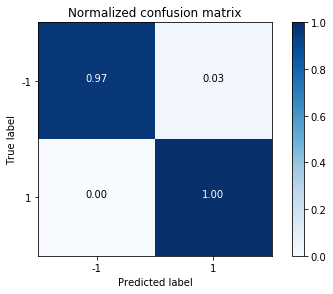

In [72]:
class_names = [-1, 1]
cnf_matrix = confusion_matrix(y, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)

## Curva ROC 
La curva de *Característica Operativa del Receptor* es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario según se varía el umbral de discriminación. El área bajo la curva ROC es 0.98. 

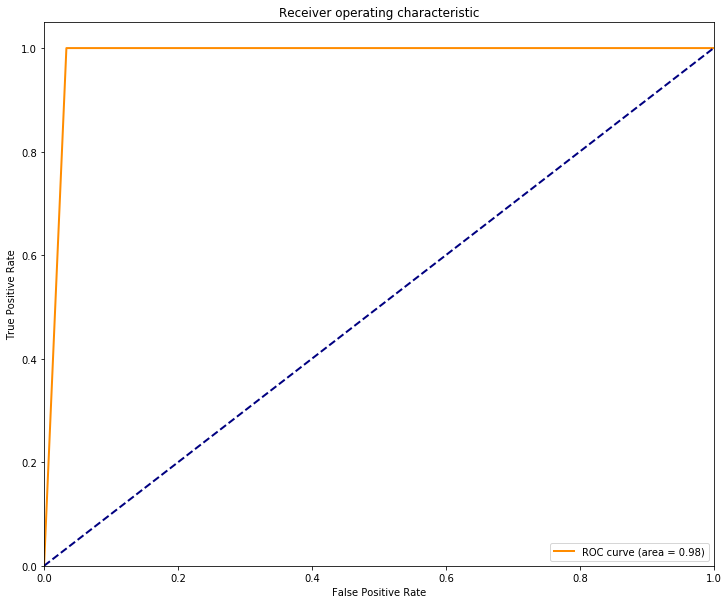

In [73]:
plot_roc_curve(y_pred,y)